In [15]:
import random
from collections import defaultdict

# Definición de trabajos y sus operaciones: (máquina, duración)
jobs = {
    'J1': [('M1', 3), ('M2', 2), ('M3', 2)],
    'J2': [('M2', 2), ('M1', 4), ('M3', 3)],
    'J3': [('M3', 3), ('M2', 3), ('M1', 2)],
    'J4': [('M1', 2), ('M3', 1), ('M2', 4)],
    'J5': [('M2', 4), ('M3', 3), ('M1', 3)],
    'J6': [('M3', 2), ('M1', 3), ('M2', 2), ('M3', 1)] 
}

machines = ['M1', 'M2', 'M3']

# Lista total de operaciones codificadas como (job_id, operation_index)
all_operations = []
for job, ops in jobs.items():
    for idx in range(len(ops)):
        all_operations.append((job, idx))


## Construir cronograma y calcular tiempo de ejecución (makespan)

In [16]:
def build_schedule(individual):
    job_ready_time = defaultdict(int)
    machine_ready_time = defaultdict(int)
    schedule = {}

    for (job, op_idx) in individual:
        machine, duration = jobs[job][op_idx]
        start_time = max(job_ready_time[job], machine_ready_time[machine])
        end_time = start_time + duration

        schedule[(job, op_idx)] = (start_time, end_time)
        job_ready_time[job] = end_time
        machine_ready_time[machine] = end_time

    return schedule

def makespan(schedule):
    return max(end for (_, end) in schedule.values())


## Generar individuos válidos

In [17]:
def generate_individual():
    job_counters = {job: 0 for job in jobs}
    ops = []
    pending = []

    # Añadir una operación inicial de cada trabajo
    for job in jobs:
        pending.append((job, 0))

    while pending:
        op = random.choice(pending)
        ops.append(op)
        job, idx = op
        pending.remove(op)
        if idx + 1 < len(jobs[job]):
            pending.append((job, idx + 1))
    return ops

def create_population(size=10):
    return [generate_individual() for _ in range(size)]


## Fitness y operadores genéticos

In [18]:
def fitness(individual):
    schedule = build_schedule(individual)
    return -makespan(schedule)  # Negativo porque el GA maximiza

def selection(population):
    a, b = random.sample(population, 2)
    return a if fitness(a) > fitness(b) else b

def crossover(p1, p2):
    size = len(p1)
    cut1, cut2 = sorted(random.sample(range(size), 2))
    middle = p1[cut1:cut2]
    remaining = [op for op in p2 if op not in middle]
    child = remaining[:cut1] + middle + remaining[cut1:]
    return child

def mutate(ind, prob=0.2):
    if random.random() < prob:
        i, j = random.sample(range(len(ind)), 2)
        ind[i], ind[j] = ind[j], ind[i]
    return ind


## Ciclo evolutivo

In [19]:
def evolve(population, generations=30):
    for gen in range(generations):
        new_pop = []
        for _ in range(len(population)):
            p1 = selection(population)
            p2 = selection(population)
            child = crossover(p1, p2)
            child = mutate(child)
            new_pop.append(child)
        population = new_pop
        best = max(population, key=fitness)
        print(f"Gen {gen+1:2d} | Makespan: {-fitness(best)}")
    return best

# Ejecutar
population = create_population(10)
best_solution = evolve(population)


Gen  1 | Makespan: 21
Gen  2 | Makespan: 21
Gen  3 | Makespan: 21
Gen  4 | Makespan: 19
Gen  5 | Makespan: 19
Gen  6 | Makespan: 19
Gen  7 | Makespan: 19
Gen  8 | Makespan: 19
Gen  9 | Makespan: 19
Gen 10 | Makespan: 20
Gen 11 | Makespan: 19
Gen 12 | Makespan: 20
Gen 13 | Makespan: 20
Gen 14 | Makespan: 20
Gen 15 | Makespan: 19
Gen 16 | Makespan: 20
Gen 17 | Makespan: 18
Gen 18 | Makespan: 18
Gen 19 | Makespan: 18
Gen 20 | Makespan: 18
Gen 21 | Makespan: 18
Gen 22 | Makespan: 18
Gen 23 | Makespan: 17
Gen 24 | Makespan: 17
Gen 25 | Makespan: 17
Gen 26 | Makespan: 17
Gen 27 | Makespan: 17
Gen 28 | Makespan: 17
Gen 29 | Makespan: 17
Gen 30 | Makespan: 17


## Visualización de la mejor solución

In [20]:
print("\n Mejor programación encontrada:")
schedule = build_schedule(best_solution)
for op, (start, end) in sorted(schedule.items(), key=lambda x: x[1][0]):
    job, idx = op
    machine = jobs[job][idx][0]
    print(f"{job} Op{idx+1} en {machine}: {start} → {end}")

print(f"\n🕒 Makespan total: {makespan(schedule)}")



 Mejor programación encontrada:
J5 Op2 en M3: 0 → 3
J1 Op1 en M1: 0 → 3
J3 Op2 en M2: 0 → 3
J6 Op1 en M3: 3 → 5
J5 Op1 en M2: 3 → 7
J4 Op1 en M1: 3 → 5
J2 Op3 en M3: 5 → 8
J6 Op2 en M1: 5 → 8
J4 Op3 en M2: 7 → 11
J3 Op1 en M3: 8 → 11
J2 Op2 en M1: 8 → 12
J6 Op3 en M2: 11 → 13
J1 Op3 en M3: 11 → 13
J3 Op3 en M1: 12 → 14
J2 Op1 en M2: 13 → 15
J4 Op2 en M3: 13 → 14
J5 Op3 en M1: 14 → 17
J6 Op4 en M3: 14 → 15
J1 Op2 en M2: 15 → 17

🕒 Makespan total: 17


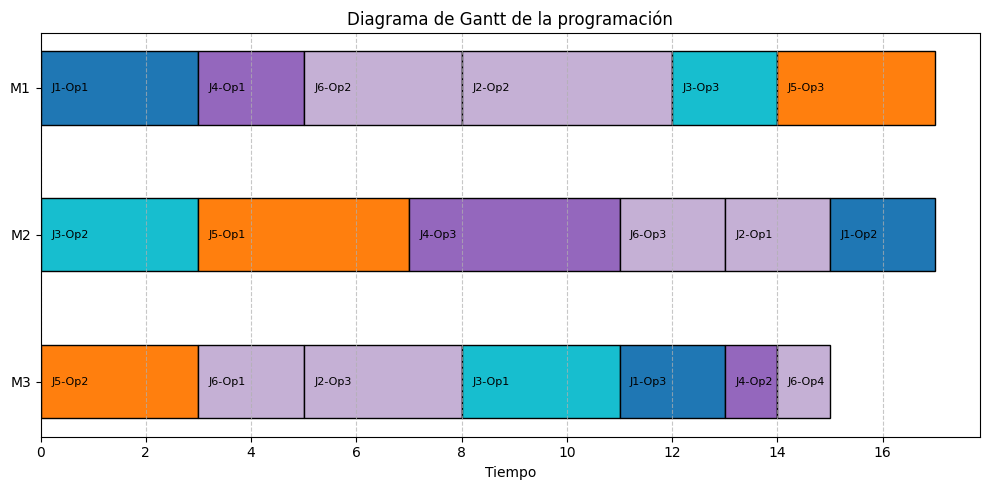

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_gantt(schedule):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = plt.cm.tab20.colors
    machine_y = {'M1': 3, 'M2': 2, 'M3': 1}
    
    for i, ((job, op_idx), (start, end)) in enumerate(schedule.items()):
        machine, duration = jobs[job][op_idx]
        y = machine_y[machine]
        color = colors[hash(job) % len(colors)]
        
        ax.barh(y, end - start, left=start, height=0.5, color=color, edgecolor='black')
        ax.text(start + 0.2, y, f'{job}-Op{op_idx+1}', va='center', ha='left', color='black', fontsize=8)
    
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['M3', 'M2', 'M1'])
    ax.set_xlabel('Tiempo')
    ax.set_title('Diagrama de Gantt de la programación')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Mostrar Gantt
plot_gantt(schedule)
